## Make effect plots

Imports.

In [1]:
from matplotlib.lines import Line2D # custom legend
import matplotlib.pyplot as plt # make simple visualizationss
import pandas as pd # data management
import seaborn as sns # simplified plotting interface

import io_helpers # file I/O

print(f'''
This notebook adds:
Seaborn version {sns.__version__}
''')


This I/O helper file uses:
Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)],
Matplotlib version 3.7.1,
pandas version 1.5.3


This notebook adds:
Seaborn version 0.12.2



Constants.

In [2]:
gene_map = io_helpers.read_col('data', 'expression', 'gene_name_map.csv',
                               colname='gene_name', index_col='ensembl_id')
tissue_map = io_helpers.read_col('data', 'expression', 'tissue_name_map.csv', 
                                 colname='long_name', index_col='short_name')

sample_info = io_helpers.load_sample_info_and_haplogroups(add_female_to_y=True)
male_rfids = sample_info.index[sample_info['sex'] == 'M']

metabolite_name = 'MZ531.3646417_5.08009'
metabolite_level = io_helpers.read_col(
    'data', 'phenotypes', f'{metabolite_name}.txt', 
    colname='pheno', index_col=1, sep='\t', names=['FID', 'pheno']
    )

Helper functions.

In [3]:
def read_expression(gene_id: str, tissue: str) -> pd.Series:
    """Read expression of one gene in one tissue.
    
    Parameters
    ----------
    gene_id: str
        Ensembl ID of the gene.
    tissue: str
        Short name of the tissue.
    
    Returns
    -------
    expr: pd.Series
        TMM-normalized CPM expression labeled by RFIDs.
    """

    expr = io_helpers.read_col('data', 'expression', 
                               f'{gene_id}_{tissue}_expr.csv', 
                               colname='expr', index_col='rfid')
    # make sure the index stays a string for comparison with group labels
    expr.index = expr.index.astype('str')
    return expr

def read_all_male_tissue_expression(gene_name: str) -> pd.DataFrame:
    """Read expression of one gene in all tissues from males.

    Short tissue names used. Sample IDs constructed as
    <RFID>_<tissue> to differentiate samples between tissues.
    
    Parameters
    ----------
    gene_name: str
        Common name of gene.

    Returns
    -------
    expr: pd.DataFrame
        Expression level and tissue, labeled by sample IDs.
    """

    gene_id = gene_map.index[gene_map == gene_name][0]
    all_expr = []

    for tissue in tissue_map.index:
        cur_expr = read_expression(gene_id, tissue).to_frame()
        cur_expr = cur_expr.filter(items=male_rfids, axis='index')

        cur_expr['rfid'] = cur_expr.index
        cur_expr.index = cur_expr['rfid'] + '_' + tissue
        cur_expr['tissue'] = tissue

        all_expr.append(cur_expr)
    return pd.concat(all_expr)

def effect_plot(phenotypes: pd.Series, groups: pd.Series, title: str, 
                ylabel: str, basename: str, extension: str = 'svg',
                width: float = 5, height: float = 3,
                blue_rfids: pd.Series = None, blue_label: str = None) -> None:
    """Create a basic effect plot.

    Parameters
    ----------
    phenotypes: pd.Series
        Phenotype values to plot on x, with RFIDs as index.
    groups: pd.Series
        Groups to plot on y, with RFIDs as index.
    title: str
        Title of the plot. Italicized.
    ylabel: str
        Y axis label of the effect plot.
    basename: str
        Part of filename: <basename>_effect_plot.<extension>.
    extension: str, default 'svg'
        Part of filename: <basename>_effect_plot.<extension>.
    width: float, default 5
        Width (in inches) of effect plot.
    height: float, default 3
        Height (in inches) of effect plot.
    blue_rfids: pd.Series, default=None
        RFIDs to plot as blue points instead of black ones.
    blue_label: str, optional
        Text to label the RFIDs with in legend. Italicized.
    """

    rfids = phenotypes.index.intersection(groups.dropna().index)

    if blue_rfids is None: black_rfids = rfids
    else:
        black_rfids = rfids[~rfids.isin(blue_rfids)]
        blue_rfids = blue_rfids[blue_rfids.isin(rfids)]

    group_subset = groups[rfids]
    group_n = group_subset.map(group_subset.value_counts()).astype(str)
    groups_with_n = group_subset + '\n n=' + group_n
    group_order = sorted(groups_with_n.unique())

    sns.violinplot(x=groups_with_n[rfids], y=phenotypes[rfids], color='white', 
                   order=group_order, inner='quart', scale='width')
    sns.stripplot(x=groups_with_n[black_rfids], y=phenotypes[black_rfids],
                  jitter=0.2, order=group_order, color='black')
    
    if blue_rfids is not None:
        sns.stripplot(x=groups_with_n[blue_rfids], y=phenotypes[blue_rfids], 
                      jitter=0.2, color='blue')
        blue_dot = Line2D([0], [0], marker='o', markerfacecolor='blue', 
                          linestyle='None', label=blue_label)
        plt.legend(handles=[blue_dot], prop={'style': 'italic'})
    
    plt.title(title, style='italic')
    plt.xlabel('')
    plt.ylabel(ylabel, fontsize=14)
        
    fig = plt.gcf()
    fig.set_size_inches(width, height)
    fig.tight_layout()

    io_helpers.save_plot(f'{basename}_effect_plot', extension=extension)

def single_gene_effect_plot(tissue: str, gene_id: str, chrom: str) -> None:
    """Create a single gene-tissue expression effect plot.

    Parameters
    ----------
    tissue: str
        The tissue (short name) to use data from.
    gene_id: str
        The Ensembl ID for the gene to use data from.
    chrom: str
        The chromosome to split by haplogroup.
    """

    expr = read_expression(gene_id, tissue)
    tissue_long_name = tissue_map[tissue]
    title = (io_helpers.roman_format(f'{tissue_long_name} expression of') 
             + ' ' + gene_map[gene_id])
    effect_plot(expr, sample_info[f'{chrom}_group'], title=title, ylabel='CPM',
                basename=f'{gene_id}_{tissue}')
    # this is called in a loop, so .show() must be manually triggered
    plt.show()
    

Effect plots for significant associations.

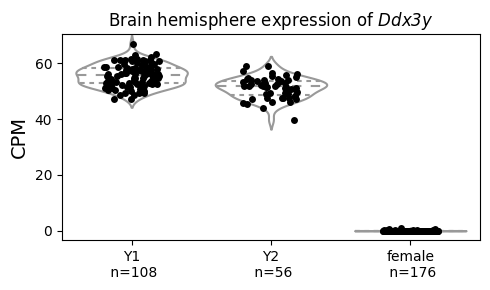

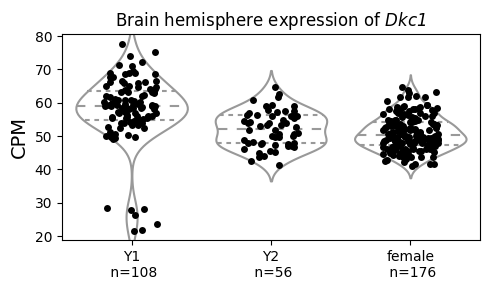

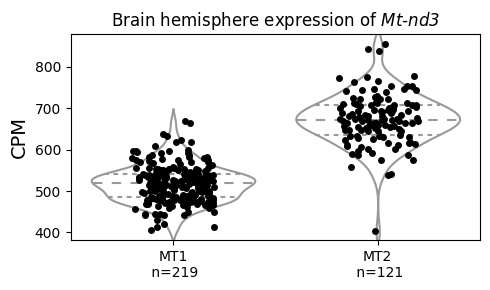

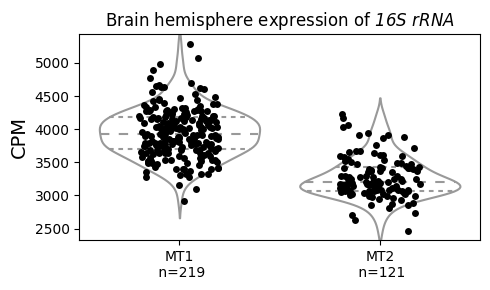

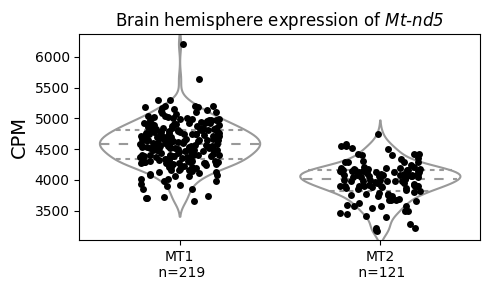

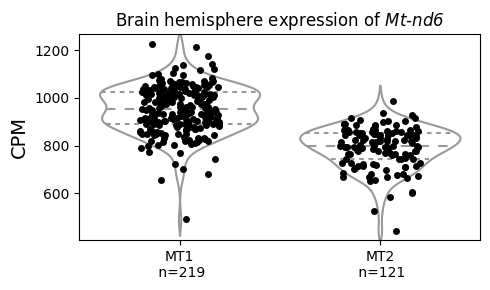

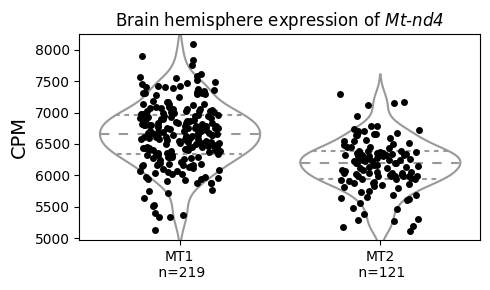

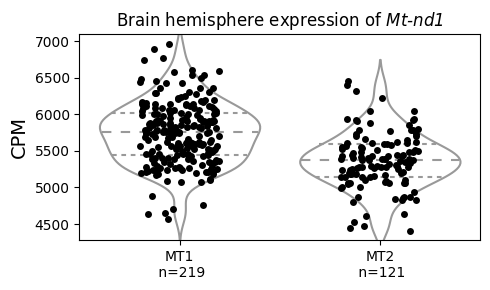

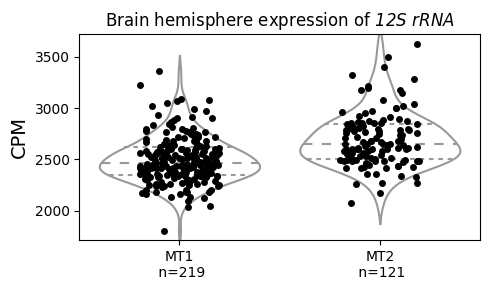

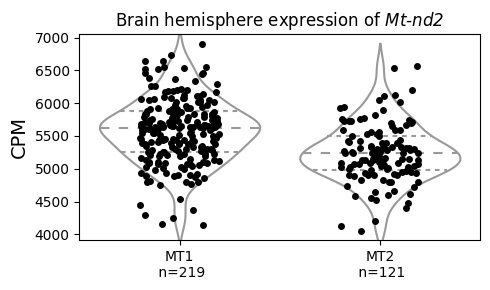

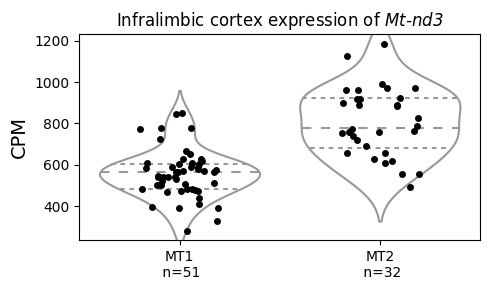

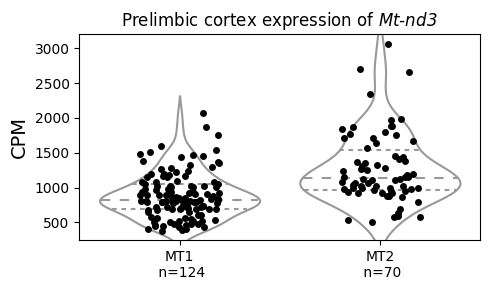

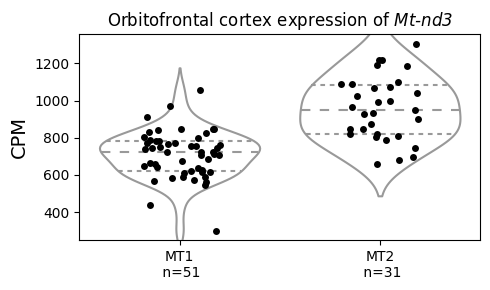

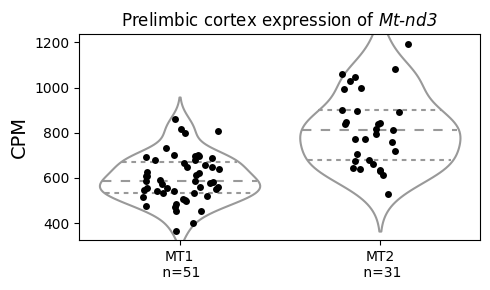

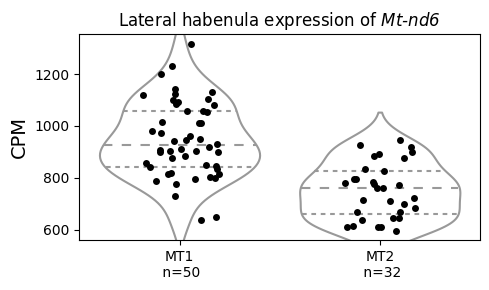

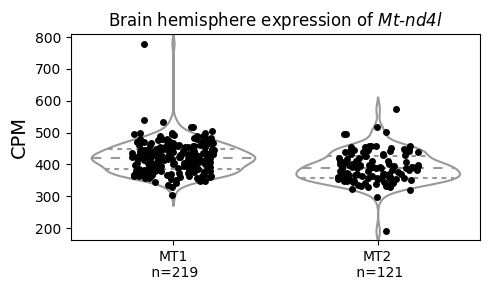

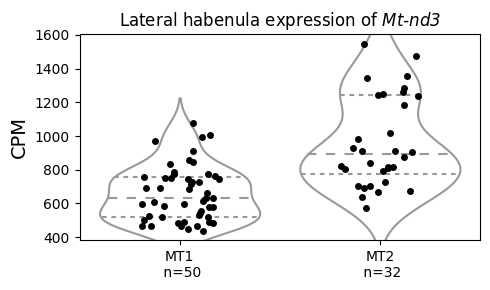

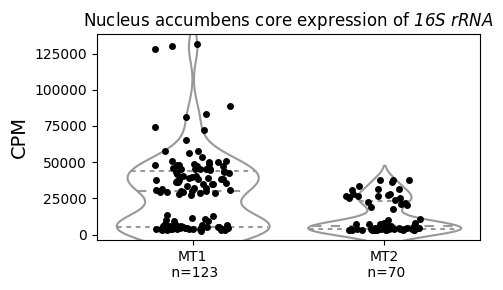

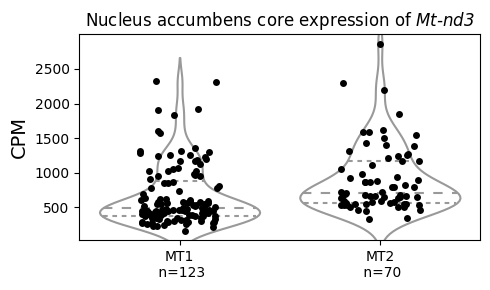

In [4]:
for chrom in ['Y', 'MT']:
    tests = io_helpers.read_csv('results', 'associations', 
                                f'{chrom}_gene_expression_tests.csv')
    
    tests.loc[tests['adj_p'] < 0.05, ['tissue', 'ensembl_id']]\
        .apply(lambda x: single_gene_effect_plot(x[0], x[1], chrom), axis=1)

Remaining effect plots use Y haplogroups without females.

In [5]:
sample_info['Y_group'].replace('female', pd.NA, inplace=True)

Plots tracking the effect of *Med14Y* deletion; see *File S1*.

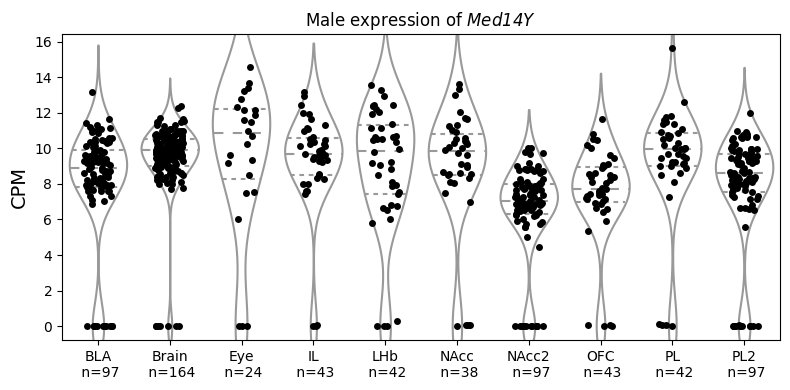

In [6]:
med14y_all_expr = read_all_male_tissue_expression('Med14Y')

# Figure A
title = io_helpers.roman_format('Male expression of') + ' Med14Y'
effect_plot(med14y_all_expr['expr'], med14y_all_expr['tissue'], title=title,
            ylabel='CPM', basename='Med14Y_expr', extension='png', width=8,
            height=4)

Remove rats with inconsistent expression of *Med14Y*. If a rat has expression in
at least *some* tissue, then it can't have a deletion of the gene. Rather, a
rare variant with tissue-specific effects, or other tissue-sample-specific
phenomena, are more likely.

In [7]:
low_med14y_rfids = med14y_all_expr.loc[med14y_all_expr['expr'] < 1, 'rfid']
high_med14y_rfids = med14y_all_expr.loc[med14y_all_expr['expr'] > 1, 'rfid']
inconsistent_rfids = set(low_med14y_rfids).intersection(set(high_med14y_rfids))

med14y_all_expr.loc[med14y_all_expr['rfid'].isin(inconsistent_rfids)]

,expr,rfid,tissue
rfid,,,
000789990A_Brain,10.819914,000789990A,Brain
000792A1F9_Brain,8.275922,000792A1F9,Brain
000789990A_Eye,0.000000,000789990A,Eye
000792A1F9_Eye,0.000000,000792A1F9,Eye


All rats with evidence for *Med14Y* deletion are of type Y1.

In [8]:
med14y_del_rfids = set(low_med14y_rfids) - set(high_med14y_rfids)

sample_info.loc[list(med14y_del_rfids), 'Y_group'].value_counts()

Y1    24
Name: Y_group, dtype: int64

Check which of the modern rats with high-coverage data have low *Med14Y*
expression; this is later used in *File S1*. See `med14y_depth.ipynb`.

In [9]:
deep_seq_tissues = ['IL', 'LHb', 'NAcc', 'OFC', 'PL']
deep_seq_tissue_rows = med14y_all_expr['tissue'].isin(deep_seq_tissues)
deep_seq_expr = med14y_all_expr.loc[deep_seq_tissue_rows]
deep_seq_expr = deep_seq_expr.pivot(columns='tissue', index='rfid')
deep_seq_expr['min_expr'] = deep_seq_expr.min(axis='columns')
deep_seq_expr.sort_values(by='min_expr').head()

expr                                            min_expr
tissue            IL        LHb       NAcc       OFC        PL          
rfid                                                                    
00078A2463  0.000000   0.000000   0.000000  0.000000  0.105365  0.000000
00078A01A6  0.000000   0.000000   0.080996  0.041701  0.000000  0.000000
00077EA7E6  0.054687   0.000000   0.051843  0.048280  0.050914  0.000000
00078A0058       NaN   0.272586   0.042283  0.000000  0.052098  0.000000
00078A021A  9.818869  12.446044  10.060476  5.358306  9.189558  5.358306

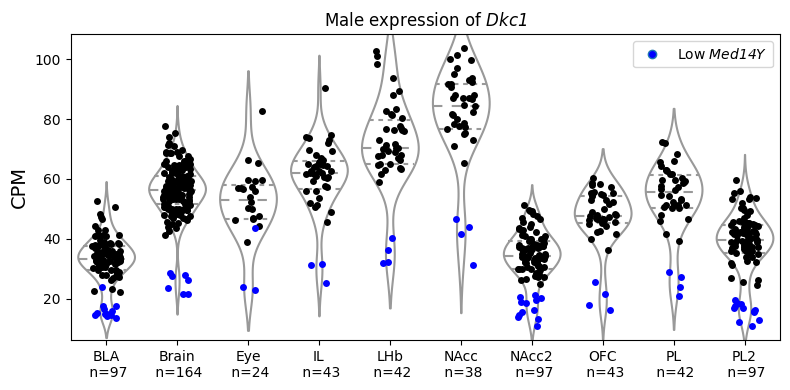

In [10]:
dkc1_all_expr = read_all_male_tissue_expression('Dkc1')
low_med14y_expr_rows = med14y_all_expr['expr'] < 1
low_med14y_sample_ids = med14y_all_expr.index[low_med14y_expr_rows]

# Figure B
effect_plot(dkc1_all_expr['expr'], dkc1_all_expr['tissue'], 
            title=io_helpers.roman_format('Male expression of') + ' Dkc1',
            ylabel='CPM', basename='Dkc1_expr_by_Med14Y', extension='png',
            width=8, height=4, blue_rfids=low_med14y_sample_ids,
            blue_label=io_helpers.roman_format('Low') + ' Med14Y')

Significant GWAS phenotype association. This is *Figure S11*.

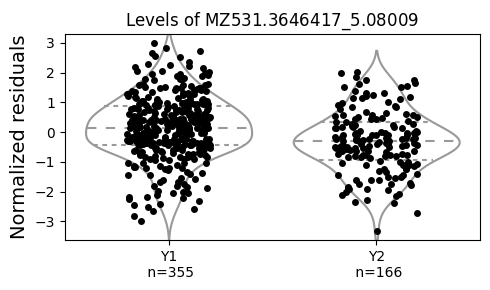

In [11]:
# the underscore is interpreted as weird formatting
escaped_metabolite = metabolite_name.replace('_', r'\_')
effect_plot(metabolite_level.dropna(), sample_info['Y_group'], 
            title=io_helpers.roman_format(f'Levels of {escaped_metabolite}'), 
            ylabel='Normalized residuals', basename='metabolite', 
            extension='png')

Replot one effect plot to show the rats with a certain SNP's alt alleles. This
is Figure *S12C*.

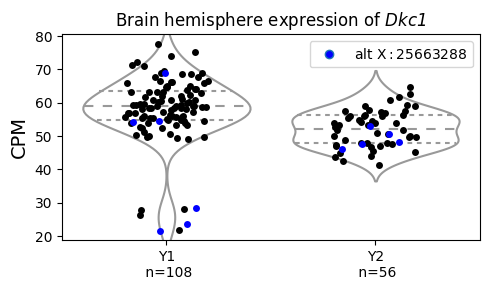

In [12]:
dkc1_id = gene_map.index[gene_map == 'Dkc1'][0]
dkc1_expr = io_helpers.read_col('data', 'expression', 
                                f'{dkc1_id}_Brain_expr.csv',
                                colname='expr', index_col='rfid')
geno = io_helpers.read_csv('data', 'genotypes', 'X_WAS_Dkc1_male_top_SNP.csv')
top_snp = geno.columns[1]

# these are the RFIDs with alt allele
alt_rfids = geno.loc[geno[top_snp] == 2, 'rfid']
alt_rfids = alt_rfids[alt_rfids.isin(dkc1_expr.index)]

title_s12c = io_helpers.roman_format('Brain hemisphere expression of') + ' Dkc1'
effect_plot(dkc1_expr, sample_info['Y_group'], title=title_s12c, ylabel='CPM', 
            basename='Dkc1_top_SNP', blue_rfids=alt_rfids, 
            blue_label=io_helpers.roman_format(f'alt {top_snp}'))